# Wprowadzenie do sieci neuronowych i uczenia maszynowego

## Lab 5b: Autoenkodery

---

**Prowadzący:** Iwo Błądek, Anna Labijak-Kowalska <br>

---

## Uwaga

* **Aby wykonać polecenia należy najpierw przejść do trybu 'playground'. File -> Open in Playground Mode**
* Nowe funkcje Colab pozwalają na autouzupełnianie oraz czytanie dokumentacji.


## Cel ćwiczeń:

- zapoznanie się z architekturą oraz zastosowaniami autoenkodera

In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

PyTorch version: 2.7.0+cu126
CUDA available: True


100%|██████████| 9.91M/9.91M [00:01<00:00, 8.90MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 271kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 19.1MB/s]


## Autoenkodery

Ideę autoenkodera prezentuje poniższy rysunek:
![label-autoencoder_schema](https://drive.google.com/uc?export=view&id=1Ai2ER1ppKfnHg5t_lCwO_fvvFNe59dgd)

Widzimy tutaj, że obrazek ze zbioru MNIST o rozmiarze 28 x 28 został skompresowany przez **enkoder** do tensora o rozmiarze 5 x 2. Tensor ten nosi nazwę **wektora zmiennych ukrytych** (ang. latent vector). Następnie **dekoder** przyjął ten wektor na wejście, i odtworzył oryginalny obrazek. Jest to przykład zadania **autoasocjacji**, gdzie celem uczenia sieci neuronowej jest możliwie wierne odtworzenie danych wejściowych. Zadanie to może się wydawać bez sensu w odosobnieniu (po co odtwarzać coś, co już mamy?), jednak to co nas najbardziej interesuje w autoenkoderze to wektor zmiennych ukrytych. Jako że skompresowaliśmy cały obrazek do 10 wartości, to by realistyczne odtworzenie z nich oryginalnego obrazka było możliwe, każda z tych wartości musi 1) zawierać o nim możliwie dużo informacji, 2) nieistotne detale oryginalnego obrazka muszą zostać pominięte. Wyciągnęliśmy więc z danych informacyjną "esencję", pozbyliśmy się redundatnych elementów opisu.

<br>

Najważniejszą cechą autoenkodera jest właśnie **uczenie się efektywnego kodowania danych**, co zazwyczaj wiąże się z redukcją wymiarowości (tzw. 'undercomplete autoencoders'), choć można też uczyć autoenkodery o kodowaniu zwiększającym wymiarowość (tzw. 'overcomplete autoencoders'; dodaje się wtedy dodatkowe ograniczenia). Skupimy się na autoenkoderach zmniejszających wymiarowość, bo ich uczenie jest znacznie prostsze. W przeciwieństwie do np. PCA kodowanie uzyskane przez taki autoenkoder może być nieliniowe, tak więc zmienne ukryte mają więcej elastyczności w reprezentacji danych. Selekcja atrybutów, której podstawy omawialiśmy wcześniej na przedmiocie, również redukuje wymiarowość, ale nie zmienia informacji w atrybutach. W ogólności techniki redukcji wymiarowości tworzą zupełnie nowe atrybuty ze starych (np. $Y_1 = 0.5X_1 - 0.25X_2^2 + \log_2 X_3$, gdzie $Y_1$ to nowy atrybut, a $X_i$ to oryginalne atrybuty). Wiele zastosowań autoenkoderów buduje właśnie na tej zdolności, a także na tym, że dzięki procesowi uczenia sieci tworzymy metodę redukcji wymiarowości zoptymalizowaną do konkretnego problemu.

<br>

Autoenkodery mają wiele potencjalnych zastosowań, przykładowo:
* Redukcja wymiarowości - uczymy autoenkoder w trybie autoasocjacji, i naszym celem jest zmniejszenie wymiarowości danych, czyli zastąpienie oryginalnego obiektu jego wektorem zmiennych ukrytych. Można użyć jako alternatywy dla selekcji atrybutów i dedykowanych metod redukcji wymiarowości (PCA, LDA, etc.).
* Grupowanie - uczymy autoenkoder w trybie autoasocjacji, wykorzystujemy wektory zmiennych ukrytych uzyskane dla danych uczących jako wejście do algorytmu grupowania (np. k-means).
* Wyszukiwanie informacji - uczymy autoenkoder w trybie autoasocjacji, wykorzystujemy wektor zmiennych ukrytych jako hasz obiektu. Jeżeli chcemy znaleźć w bazie danych obiekty podobne do zadanego obiektu $X$, to generujemy wektor zmiennych ukrytych (hasz) $X$ przy użyciu enkodera i szukamy obiektów w zbiorze o najbardziej zbliżonych haszach. Technika ta nazywana jest haszowaniem semantycznym.
* Wykrywanie anomalii - uczymy autoenkoder w trybie autoasocjacji wyłącznie na przypadkach "normalnych". Liczymy na to, że jak kiedykolwiek autoenkoder dostanie do przetworzenia przypadek odstający/anomalię, to nie da rady jej dobrze zrekonstruować i błąd będzie wysoki (właśnie przez to, że nie miał szansy się na nich nauczyć).
* Generowanie danych - uczymy autoenkoder w trybie autoasocjacji, a następnie jak chcemy uzyskać różne warianty danego obrazu/obiektu, to modyfikujemy jego wygenerowany przez enkoder wektor zmiennych ukrytych, i dajemy go do przetworzenia dekoderowi. Możemy też po prostu losowo próbkować przestrzeń wektorów ukrytych i obserwować wyniki po przetworzeniu przez dekoder. Przy odrobinie szczęścia jakaś zmienna ukryta może np. odpowiadać za wyraz twarzy człowieka, i zmieniając wartości tej zmiennej możemy zmieniać wyłącznie wyraz twarzy człowieka na zdjęciu. Do tego zadania zazwyczaj wykorzystywany jest zmodyfikowany wariant autoenkodera: autoenkoder wariacyjny.
* Odszumianie - uczymy autoenkoder w trybie heteroasocjacji: *zaszumiony obraz* -> *oryginalny obraz*. Liczymy na to, że enkoder i dekoder nauczą się poprawnie rozpoznawać szum jako element redundantny, nieniosący żadnej informacji.<br>
![label-autoencoder_denoising](https://drive.google.com/uc?export=view&id=1a1fP7CWjzKSwo0txUBUMwaxTrpt6LzyH)



### Zadanie 1

Zaimplementuj autoenkoder o następującej architekturze:
* Enkoder: Dense(100) -> Dense(50) -> Dense(10) (wektor zmiennych ukrytych).
* Dekoder: Dense(50) -> Dense(100) -> Dense(784) (wyjściowy zrekonstruowany obrazek)

gdzie Dense(n) oznacza warstwę w pełni połączoną z *n* neuronami i funkcją aktywacji ReLU (użyj odpowiednich dla PyTorch klas). Jako miarę błędu przyjmij MSE.

In [24]:
import torch
import torch.nn as nn
import torch.nn.init as init

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 784),
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                init.constant_(m.bias, 0)

    def forward(self, x):
        # Zepewnij, że wejście jest spłaszczone do jednego wymiaru
        x = x.view(-1, 784)

        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)

        # Przywróć wyjście do oryginalnego wymiaru
        decoded = decoded.view(-1, 1, 28, 28)

        return decoded


# Zmodyfikuj pętlę treningowa i testowa
def train_and_test(
        train_loader,
        test_loader,
        model,
        optimizer,
        criterion,
        epochs=10,
        verbose=False,
    ):
    epochs_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()

            # Oblicz loss (pamiętaj, że jest to zadanie autoasocjacji)
            loss = criterion(model(data), data)

            loss.backward()
            optimizer.step()

            if verbose and batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
            train_loss += loss.item() * data.size(0)
        if verbose:
            train_loss /= len(train_loader.dataset)
            print(f"Train loss: {train_loss:.4f}")

        model.eval()
        test_metric = 0
        test_loss = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            # Oblicz test loss (pamiętaj, że jest to zadanie autoasocjacji)
            loss = criterion(model(data), data)

            test_loss += loss.item() * data.size(0)
        if verbose:
            test_loss /= len(test_loader.dataset)
            test_metric /= len(test_loader.dataset)
            print(f"Test loss: {test_loss:.4f}")
            print("-------------------------------")

        epochs_history.append({
          "epoch": epoch,
          "train_loss": train_loss,
          "test_loss": test_loss,
        })
    return epochs_history

model = Autoencoder()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, epochs=10, verbose=True)

Epoch: 0, Batch: 0, Loss: 0.2709
Epoch: 0, Batch: 100, Loss: 0.0626
Epoch: 0, Batch: 200, Loss: 0.0599
Epoch: 0, Batch: 300, Loss: 0.0584
Epoch: 0, Batch: 400, Loss: 0.0533
Train loss: 0.0633
Test loss: 0.0523
-------------------------------
Epoch: 1, Batch: 0, Loss: 0.0508
Epoch: 1, Batch: 100, Loss: 0.0475
Epoch: 1, Batch: 200, Loss: 0.0479
Epoch: 1, Batch: 300, Loss: 0.0467
Epoch: 1, Batch: 400, Loss: 0.0449
Train loss: 0.0475
Test loss: 0.0442
-------------------------------
Epoch: 2, Batch: 0, Loss: 0.0430
Epoch: 2, Batch: 100, Loss: 0.0429
Epoch: 2, Batch: 200, Loss: 0.0432
Epoch: 2, Batch: 300, Loss: 0.0423
Epoch: 2, Batch: 400, Loss: 0.0422
Train loss: 0.0421
Test loss: 0.0394
-------------------------------
Epoch: 3, Batch: 0, Loss: 0.0407
Epoch: 3, Batch: 100, Loss: 0.0408
Epoch: 3, Batch: 200, Loss: 0.0388
Epoch: 3, Batch: 300, Loss: 0.0379
Epoch: 3, Batch: 400, Loss: 0.0374
Train loss: 0.0384
Test loss: 0.0373
-------------------------------
Epoch: 4, Batch: 0, Loss: 0.0368

### Zadanie 2

Użyj zaimplementowanego w poprzednim zadaniu autoenkodera by zaobserwować jak zmienia się odtwarzany obraz gdy zmienia się tylko jeden element wektora zmiennych ukrytych. Zadanie wykonywane jest w następujących krokach:
1. Użyj nauczonego enkodera z poprzedniego zadania na przypadku uczącym wybranej cyfry (dowolnej) by uzyskać wektor zmiennych ukrytych.
2. Wybierz konkretną zmienną ukrytą w tym wektorze, np. tę o indeksie 0.
3. W pętli podstawiaj różne wartości do tej zmiennej wektora z pewnym krokiem, i obserwuj obrazki generowane przez dekoder.

Original image


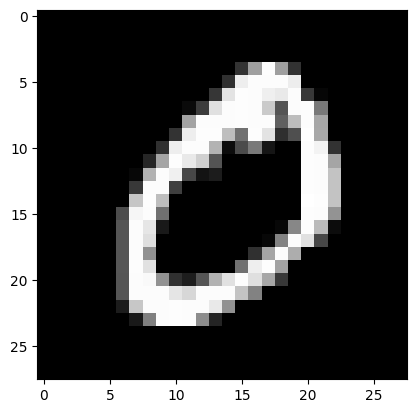

Reconstructed image


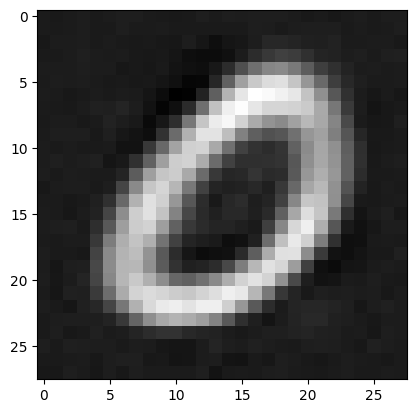

latent_vector: tensor([[ 0.2138,  0.2716,  1.7370, -2.5808, -1.2466, -1.5744,  1.5734,  0.7952,
          0.6447,  0.6699]], grad_fn=<AddmmBackward0>)
e: -2.580796957015991


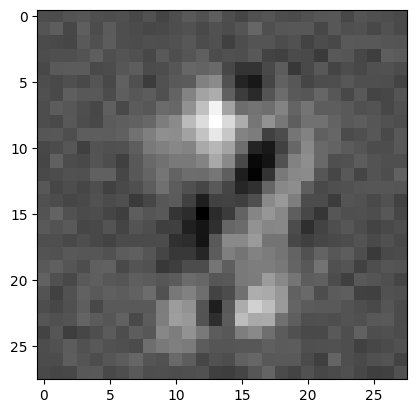

e: -2.1490209102630615


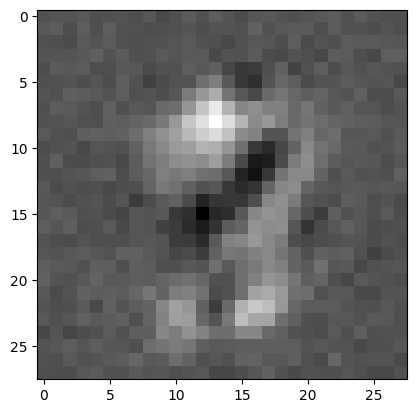

e: -1.7172448635101318


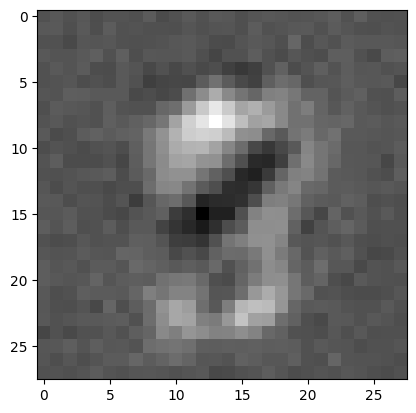

e: -1.2854688167572021


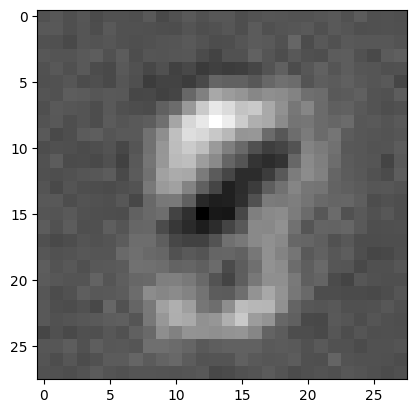

e: -0.8536927700042725


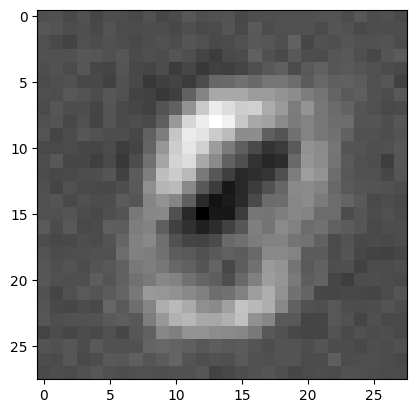

e: -0.4219167232513428


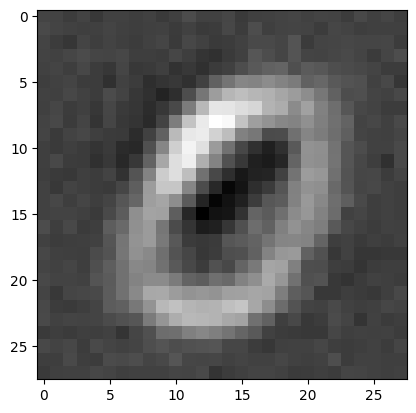

e: 0.009859323501586914


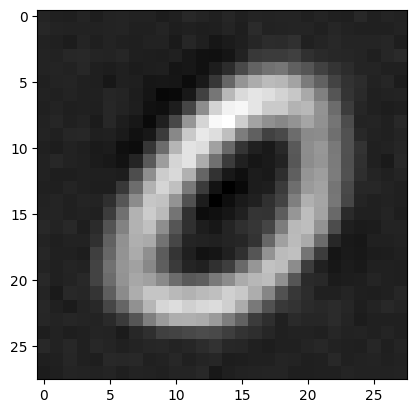

e: 0.4416353702545166


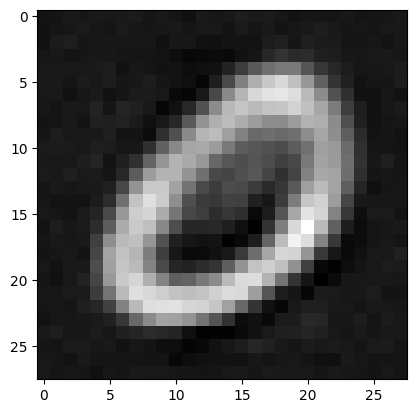

e: 0.8734114170074463


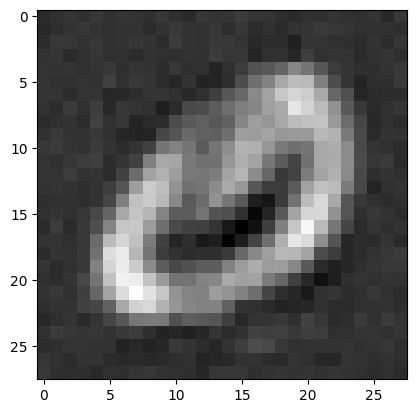

e: 1.305187463760376


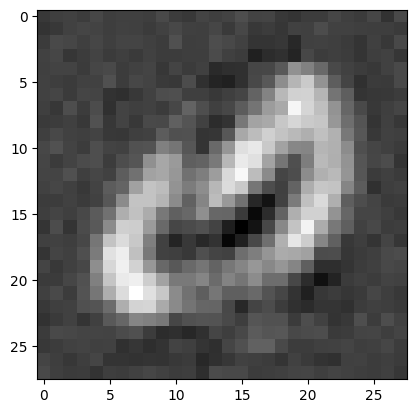

e: 1.7369635105133057


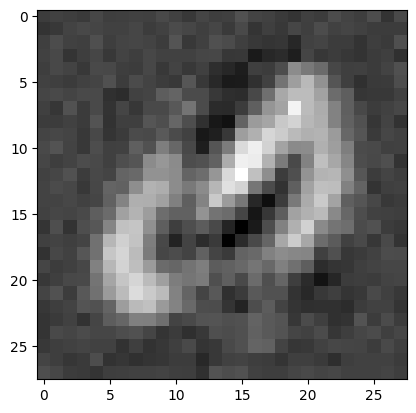

In [47]:
example = train_data[1][0]
print("Original image")
plt.imshow(example.reshape((28, 28)), cmap='gray')
plt.show()

# Po uczeniu wykonanym w poprzednim zadaniu, mamy dostęp do już nauczonych składowych sieci
latent_vector = model.encoder(example.view(-1, 784))
output = model.decoder(latent_vector)

print("Reconstructed image")
plt.imshow(output.detach().numpy().reshape(28, 28), cmap='gray')
plt.show()

print(f"latent_vector: {latent_vector}")

for e in torch.linspace(torch.min(latent_vector), torch.max(latent_vector), 11):
    print(f"e: {e}")

    # Zmień wektor zmiennych ukrytych, ustawiając wartość e w odpowiednim polu wektora
    modified_latent = latent_vector.clone()
    modified_latent[0, 0] = e
    # Użyj dekodera by wygenerować obrazek z nowego wektora zmiennych ukrytych
    new_output = model.decoder(modified_latent)
    # Pokaż wynikowy obrazek
    plt.imshow(new_output.detach().numpy().reshape(28, 28), cmap='gray')
    plt.show()

### Zadanie 3

Wykorzystaj kod z poprzednich zadań by nauczyć autoenkoder odszumiania. Parę uwag:
* Musisz zmodyfikować zbiór uczący poprzez dodanie sztucznego szumu. Można to zrobić albo poprzez zmianę wartości kilku losowych pikseli w każdym obrazku, albo dodanie macierzy z małymi losowo generowanymi liczbami do obrazka (do każdego obrazka innej!). Oczekiwaną odpowiedzą podczas uczenia będzie oryginalny obrazek bez szumu.
* Architektura enkodera i dekodera może pozostać bez zmian, ale będziesz musiał ją nauczyć na nowym zbiorze danych, tak więc by nie psuć wyników z zadania nr 1 sugeruję przeklejenie odpowiedniego kodu tutaj.
* Zademonstruj działanie odszumiania poprzez pokazanie przypadku z szumem, a następnie zrekonstruowanego obrazka bez szumu po przetworzeniu przez autoenkoder.

In [56]:
class NoisyMNIST(Dataset):
    def __init__(self, base_ds, noise_factor=0.4):
        self.base = base_ds
        self.noise_factor = noise_factor

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, _ = self.base[idx]
        noise = torch.randn_like(img) * self.noise_factor
        noisy = torch.clamp(img + noise, 0, 1)
        return noisy, img

In [57]:
noise_factor = 0.5
train_noisy = NoisyMNIST(train_data, noise_factor)
test_noisy  = NoisyMNIST(test_data,  noise_factor)

train_loader_noisy = DataLoader(train_noisy, batch_size=128, shuffle=True)
test_loader_noisy  = DataLoader(test_noisy,  batch_size=128)

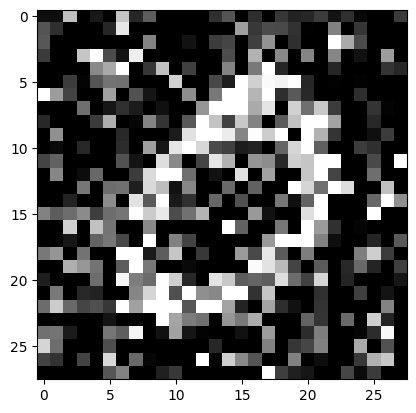

In [75]:
example = train_noisy[1][0]
plt.imshow(example.reshape((28, 28)), cmap='gray')

In [76]:
model = Autoencoder()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
_ = train_and_test(train_loader_noisy, test_loader_noisy, model, optimizer, criterion, epochs=10, verbose=True)

Epoch: 0, Batch: 0, Loss: 1.4089
Epoch: 0, Batch: 100, Loss: 0.1107
Epoch: 0, Batch: 200, Loss: 0.1066
Epoch: 0, Batch: 300, Loss: 0.1039
Epoch: 0, Batch: 400, Loss: 0.1036
Train loss: 0.1195
Test loss: 0.1038
-------------------------------
Epoch: 1, Batch: 0, Loss: 0.1048
Epoch: 1, Batch: 100, Loss: 0.1033
Epoch: 1, Batch: 200, Loss: 0.1025
Epoch: 1, Batch: 300, Loss: 0.1033
Epoch: 1, Batch: 400, Loss: 0.1022
Train loss: 0.1028
Test loss: 0.1019
-------------------------------
Epoch: 2, Batch: 0, Loss: 0.1010
Epoch: 2, Batch: 100, Loss: 0.1015
Epoch: 2, Batch: 200, Loss: 0.1001
Epoch: 2, Batch: 300, Loss: 0.0994
Epoch: 2, Batch: 400, Loss: 0.0983
Train loss: 0.1003
Test loss: 0.0990
-------------------------------
Epoch: 3, Batch: 0, Loss: 0.0982
Epoch: 3, Batch: 100, Loss: 0.0991
Epoch: 3, Batch: 200, Loss: 0.0973
Epoch: 3, Batch: 300, Loss: 0.0976
Epoch: 3, Batch: 400, Loss: 0.0976
Train loss: 0.0983
Test loss: 0.0973
-------------------------------
Epoch: 4, Batch: 0, Loss: 0.0972

Original image


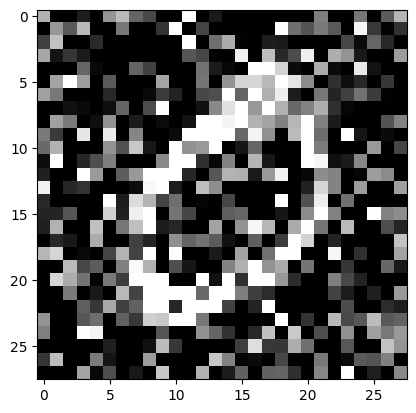

Reconstructed image


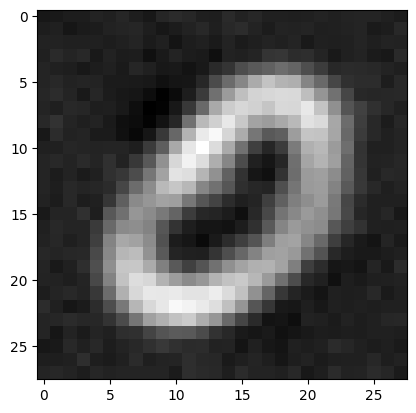

In [87]:
example = train_noisy[1][0]
print("Original image")
plt.imshow(example.reshape((28, 28)), cmap='gray')
plt.show()

# Po uczeniu wykonanym w poprzednim zadaniu, mamy dostęp do już nauczonych składowych sieci
latent_vector = model.encoder(example.view(-1, 784))
output = model.decoder(latent_vector)

print("Reconstructed image")
plt.imshow(output.detach().numpy().reshape(28, 28), cmap='gray')
plt.show()